# Classification problem with Fake and Real news


In [4]:
%run python_helper.py
%matplotlib inline 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Clean & Save Data

In [5]:
input_str = open("fake_or_real_news_training.csv",encoding="utf8")

# Remove all new lines
noNewLines = re.sub("\n", "", input_str.read())
  
noNewLines = re.sub("X1,X2", "X1,X2\n", noNewLines)
  
noNewLines = re.sub(",FAKE[,]+", ",FAKE,,\n", noNewLines)
  
noNewLines = re.sub(",REAL[,]+", ",REAL,,\n", noNewLines)
  
lines = noNewLines.split('\n')

def removeComma(g):
      t = g.groups()
      t = [t[0], t[1].replace(',', ' |'), t[2], t[3]]
      return "".join(t)

betweenQuotes = lambda line: re.sub(r'(.*,")(.*)(",)(.*)', lambda x: removeComma(x), line)

secondCol = lambda line: re.sub(r'^([0-9]+,)(.*,.*)(,\")(.*)$', lambda x: removeComma(x), line, 1)


lines = [betweenQuotes(l) for l in lines]
lines = [secondCol(l) for l in lines]

finalString = '\n'.join(lines)



### Save cleaned file

In [6]:
file = open('fake_or_real_news_training_CLEANED.csv', 'w',encoding="utf8")
file.write(finalString)
file.close()

# Data Preparation

In [7]:
train = pd.read_csv("fake_or_real_news_training_CLEANED.csv")
test = pd.read_csv("fake_or_real_news_test.csv")

In [8]:
len(train)

3997

In [9]:
len(test)

2321

In [10]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,NaN,NaN


In [11]:
train = train.drop(['X1', 'X2'], axis=1)

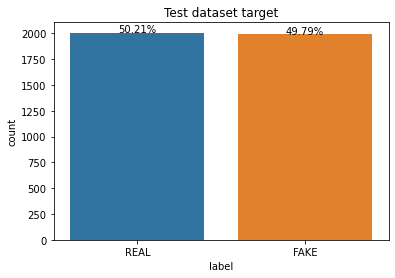

In [12]:
from collections import Counter
ax = sns.countplot(train.label, order=[x for x, count in sorted(Counter(train.label).items(), key=lambda x: -x[1])])


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center") 
ax.set_title("Test dataset target")
show()

In [13]:
test.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In [14]:
test['label'] = None  # empty label for test

df = pd.concat([train, test])

In [15]:
len(df)

6318

In [16]:
df.tail()

,ID,title,text,label
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None
2320,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None


# Data Preprocessing

In [17]:
df['title_and_text'] = df['title'] +' '+ df['text']
df.tail()

,ID,title,text,label,title_and_text
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se..."
2320,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None,Jeb Bush Is Suddenly Attacking Trump. Here's W...


In [18]:
df['preprocessed_text'] = df['title_and_text'].apply(lambda x: preprocess(x))

In [19]:
## Save preprocessed df
df.to_csv("fake_or_real_news_train_PREPROCESSED.csv", index=False)

In [20]:
df = pd.read_csv("fake_or_real_news_train_PREPROCESSED.csv")
df = df.astype(object).replace(np.nan, 'None')

In [21]:
df.tail()

,ID,title,text,label,title_and_text,preprocessed_text
6313,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...,state department say can't find emails clinton...
6314,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...
6315,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...
6316,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...
6317,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None,Jeb Bush Is Suddenly Attacking Trump. Here's W...,jeb bush suddenly attack trump here's matter j...


### Split Train and Test again after pre-processing is done

In [22]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df)


Train dataset (Full)
(3997, 7)
Train dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text', 'encoded_label']

Train CV dataset (subset)
(2677, 7)
Train Holdout dataset (subset)
(1320, 7)

Test dataset
(2321, 6)
Test dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text']


In [23]:
encoder

LabelEncoder()

# Baseline Modelling

First, we create a dataframe called models to keep track of different models and their scores.

In [24]:
models = pd.DataFrame(columns=['model_name', 'model_object', 'score'])

### Vectorizing dataset

In [25]:
count_vect = CountVectorizer(analyzer = "word")

count_vectorizer = count_vect.fit(df.preprocessed_text)

train_cv_vector = count_vectorizer.transform(train_cv.preprocessed_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.preprocessed_text)
test_vector = count_vectorizer.transform(test.preprocessed_text)

In [26]:
count_vect.get_feature_names()[:10]

['___',
 '_blank',
 '_derosa',
 '_rt_op_edge',
 '_strauss',
 'aa',
 'aaa',
 'aaahhh',
 'aab',
 'aachen']

## Baseline Model 1: SVC

Baseline Model 1: SVC
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.909 (+/-0.022) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.902 (+/-0.030) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.893 (+/-0.030) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.886 (+/-0.011) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Estimator Params
SVC(C=100, gamma

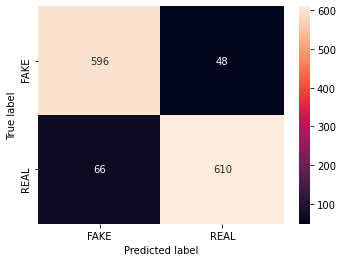


Accuracy:
0.9136363636363637


In [27]:
SVC_classifier = runModel(encoder,
               train_cv_vector,
               train_cv_label,
               train_holdout_vector,
               train_holdout.label,
               "svc",
               "Baseline Model 1: SVC")
models.loc[len(models)] = SVC_classifier

## Baseline Model 2: Naïve Bayes

Baseline Model 2: Naiive Bayes
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.887 (+/-0.021) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


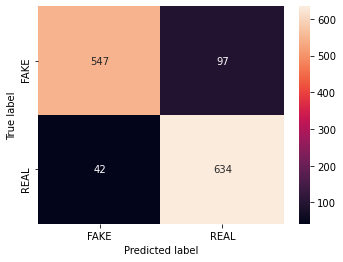


Accuracy:
0.8946969696969697


In [25]:
NB = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "nb",
              "Baseline Model 2: Naiive Bayes")
models.loc[len(models)] = NB

## Baseline Model 3: MaxEnt Classifier

Baseline Model 3: MaxEnt Classifier
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.877 (+/-0.023) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.913 (+/-0.011) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.929 (+/-0.012) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.926 (+/-0.019) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.916 (+/-0.025) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100,

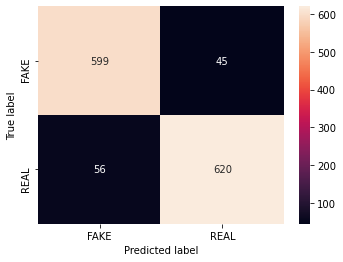


Accuracy:
0.9234848484848485


In [26]:
maxEnt = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "maxEnt",
              "Baseline Model 3: MaxEnt Classifier")
models.loc[len(models)] = maxEnt

# Baseline Models Summary

In [27]:
models

,model_name,model_object,score
0,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>
1,Baseline Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Baseline Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485


# Feature Engineeering

## 1. TF-IDF weighting

Try to add weight to each word using TF-IDF
<img src="https://cdn-images-1.medium.com/max/800/1*_OsV8gO2cjy9qcFhrtCdiw.jpeg" width="350px"/>


In [36]:
df["clean_and_pos_tagged_text"] = df['preprocessed_text'] + ' ' + df['pos_tagged_text']

In [37]:
df.head(1)

,ID,title,text,label,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...,smell hillary’s fear daniel greenfield shillma...


In [38]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

count_vect = CountVectorizer(analyzer = "word")

count_vectorizer = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = count_vectorizer.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = count_vectorizer.transform(test.clean_and_pos_tagged_text)


tf_idf = TfidfTransformer(norm="l2")
train_cv_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_tf_idf = tf_idf.fit_transform(test_vector)  

### Rerun Models on preprocessed + TF-IDF weighted text (FE1)

a. SVC with FE1

SVC on preprocessed+pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.937 (+/-0.024) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.935 (+/-0.021) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.895 (+/-0.009) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.859 (+/-0.015) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.590 (+/-0.139) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.481 (+/-0.027) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Est

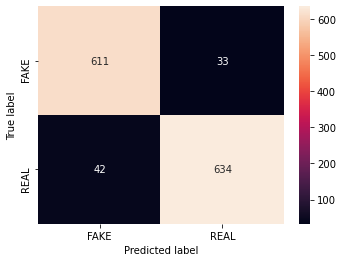


Accuracy:
0.9431818181818182


In [39]:
SVC_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
               "svc",
               "SVC on preprocessed+pos-tagged TF-IDF weighted text")
models.loc[len(models)] = SVC_tf_idf

b. NB with FE1

Naiive Bayes on preprocessed+pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.781 (+/-0.039) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


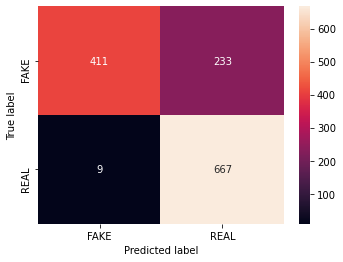


Accuracy:
0.8166666666666667


In [40]:
NB_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
              "nb",
              "Naiive Bayes on preprocessed+pos-tagged TF-IDF weighted text")
models.loc[len(models)] = NB_tf_idf

c. maxEnt with FE1 

MaxEnt on preprocessed+pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.554 (+/-0.147) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.749 (+/-0.021) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.831 (+/-0.023) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.907 (+/-0.004) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.931 (+/-0.022) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for

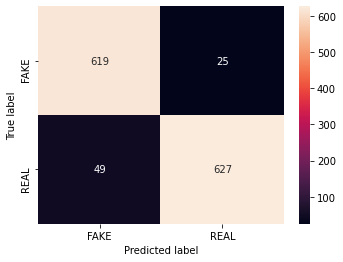


Accuracy:
0.943939393939394


In [41]:
maxEnt_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
              "maxEnt",
              "MaxEnt on preprocessed+pos-tagged TF-IDF weighted text")
models.loc[len(models)] = maxEnt_tf_idf

In [42]:
models

,model_name,model_object,score
0,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>
1,Baseline Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Baseline Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485
3,SVC on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.915909
4,Naiive Bayes on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.897727
5,MaxEnt Classifier on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.925
6,SVC on preprocessed+pos-tagged TF-IDF weighted...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182
7,Naiive Bayes on preprocessed+pos-tagged TF-IDF...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.816667
8,MaxEnt on preprocessed+pos-tagged TF-IDF weigh...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943939


<h3 style="color:blue">
Using TF-IDF increased the score to ~94.5% with SVC and Max-Ent models.
<br><br>
Naive-Bayes rather decreased the score. Therefore we drop it from the pipeline.
</h3>

## 2. Use Trigram Vectorizer instead of regular vectorizer

For FE2, we use the Trigram vectorizer, which vectorizes **triplets of words** rather than each word separately. *In this short example sentence*, the trigrams are "In this short", "this short example" and "short example sentence".

In [43]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

trigram_vect = CountVectorizer(analyzer = "word", ngram_range=(1,2))

trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = trigram_vect.transform(test.clean_and_pos_tagged_text)

In [44]:
tf_idf = TfidfTransformer(norm="l2")
train_cv_bigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_bigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_bigram_tf_idf = tf_idf.fit_transform(test_vector)

### Rerun Models on preprocessed + TF-IDF weighted (FE1) + Trigram vectorized text (FE2)

a. SVC with FE1, FE2 

SVC on bigram vect.+ TF-IDF
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.937 (+/-0.024) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.935 (+/-0.021) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.895 (+/-0.009) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.859 (+/-0.015) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.590 (+/-0.139) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.481 (+/-0.027) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Estimator Params
SVC(C=10, 

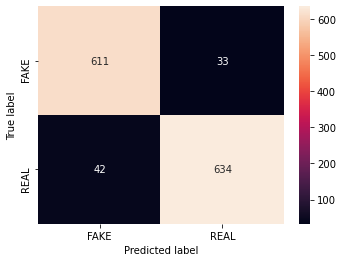


Accuracy:
0.9431818181818182


In [45]:
SVC_trigram_tf_idf = runModel(encoder,
               train_cv_bigram_tf_idf,
               train_cv_label,
               train_holdout_bigram_tf_idf,
               train_holdout.label,
               "svc",
               "SVC on bigram vect.+ TF-IDF")
models.loc[len(models)] = SVC_trigram_tf_idf

b. maxEnt with FE1, FE2

In [46]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

trigram_vect = CountVectorizer(analyzer = "word", ngram_range=(1,3))

trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)

In [47]:
tf_idf = TfidfTransformer(norm="l2")
train_cv_trigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_trigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)

MaxEnt on trigram vect.+ TF-IDF
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.554 (+/-0.147) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.749 (+/-0.021) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.831 (+/-0.023) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.907 (+/-0.004) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.931 (+/-0.022) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100, 'pe

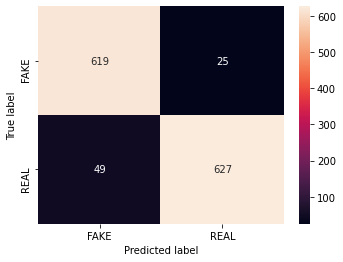


Accuracy:
0.943939393939394


In [48]:
maxEnt_tf_idf = runModel(encoder,
               train_cv_trigram_tf_idf,
               train_cv_label,
               train_holdout_trigram_tf_idf,
               train_holdout.label,
              "maxEnt",
              "MaxEnt on trigram vect.+ TF-IDF")
models.loc[len(models)] = maxEnt_tf_idf

In [49]:
models

,model_name,model_object,score
0,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>
1,Baseline Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Baseline Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485
3,SVC on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.915909
4,Naiive Bayes on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.897727
5,MaxEnt Classifier on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.925
6,SVC on preprocessed+pos-tagged TF-IDF weighted...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182
7,Naiive Bayes on preprocessed+pos-tagged TF-IDF...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.816667
8,MaxEnt on preprocessed+pos-tagged TF-IDF weigh...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943939
9,SVC on bigram vect.+ TF-IDF,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182


<h3 style="color:blue">
It looks like the "MaxEnt on trigram vect.+ TF-IDF" is the best model with the highest score. We will use it to predict and classify the testset.
</h3>

# Predicting on test dataset

## 1. Train on whole data and predict on test

### PREPROCESSED data

In [50]:
test = pd.read_csv("fake_or_real_news_test.csv")
train = pd.read_csv("fake_or_real_news_training_CLEANED.csv")

In [51]:
train['title_and_text'] = train['title'] +' '+ train['text']
train['preprocessed_text'] = train['title_and_text'].apply(lambda x: preprocess(x))

In [52]:
test['title_and_text'] = test['title'] +' '+ test['text']
test['preprocessed_text'] = test['title_and_text'].apply(lambda x: preprocess(x))

In [53]:
test.head()

,ID,title,text,title_and_text,preprocessed_text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...


In [54]:
## Save preprocessed df
train.to_csv("fake_or_real_news_train_PREPROCESSED.csv", index=False)

In [55]:
# Save preprocessed df
test.to_csv("fake_or_real_news_test_PREPROCESSED.csv", index=False)

In [56]:
train = pd.read_csv("fake_or_real_news_train_PREPROCESSED.csv")
train = train.astype(object).replace(np.nan, 'None')

test = pd.read_csv("fake_or_real_news_test_PREPROCESSED.csv")
test = test.astype(object).replace(np.nan, 'None')

In [57]:
test = test.astype(object).replace(np.nan, 'None')

In [58]:
test.head()

,ID,title,text,title_and_text,preprocessed_text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...


In [59]:
train.head()

,ID,title,text,label,X1,X2,title_and_text,preprocessed_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,None,None,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,None,None,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,None,None,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,None,None,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,None,None,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...


### POS Tagging

In [60]:
train['pos_tagged_text'] = train['preprocessed_text'].apply(lambda x: pos_tag_words(x))
test['pos_tagged_text'] = test['preprocessed_text'].apply(lambda x: pos_tag_words(x))

### merge clean and pos tagged

In [61]:
train["clean_and_pos_tagged_text"] = train['preprocessed_text'] + ' ' + train['pos_tagged_text']
test["clean_and_pos_tagged_text"] = test['preprocessed_text'] + ' ' + train['pos_tagged_text']

In [62]:
train.head(1)

,ID,title,text,label,X1,X2,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,None,None,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...,smell hillary’s fear daniel greenfield shillma...


In [63]:
test.head(1)

,ID,title,text,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...,VB-september JJ-new NN-home NN-sale JJ-rise——-...,september new home sale rise——-back level sept...


## Modelling using MaxEnt on trigram vect.+ TF-IDF Grid Search Best params

### Trigram + Tfdif + classifier pipeline

In [68]:
from sklearn.pipeline import Pipeline
trigram_vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,3))
tf_idf = TfidfTransformer(norm="l2")
classifier = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

pipeline = Pipeline([
     ('trigram_vectorizer', trigram_vectorizer),
     ('tfidf', tf_idf),
     ('clf', classifier),
 ])


In [69]:
pipeline.fit(train.clean_and_pos_tagged_text, encoder.fit_transform(train.label.values))

Pipeline(steps=[('trigram_vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1000, solver='liblinear'))])

In [70]:
import pickle
pickle.dump( pipeline, open( "pipeline.pkl", "wb" ) )

## 2. Predicting on test

In [71]:
print(colored("Predicting on test", 'blue'))
test_predictions = test_predictions = pipeline.predict(test.clean_and_pos_tagged_text)


Predicting on test


In [72]:
test_predictions

array([0, 0, 1, ..., 1, 1, 1])

In [73]:
test_predictions_decoded = encoder.inverse_transform( test_predictions )

In [74]:
predictions = test
predictions["label"] = test_predictions_decoded

In [75]:
predictions.shape

(2321, 8)

In [76]:
predictions.head()

,ID,title,text,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text,label
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...,VB-september JJ-new NN-home NN-sale JJ-rise——-...,september new home sale rise——-back level sept...,FAKE
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...,NN-obamacare NN-doomsday NN-cult MD-ca RB-n't ...,obamacare doomsday cult can't admit wrong cong...,FAKE
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...,NN-sander NNS-cruz VBP-resist NN-pressure JJ-n...,sander cruz resist pressure ny loss vow fight ...,REAL
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...,JJ-survive NN-escape NN-prisoner JJ-likely NN-...,survive escape prisoner likely fatigue prone m...,REAL
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...,NN-clinton NN-sander NN-neck NN-neck NN-califo...,clinton sander neck neck california primary ma...,REAL


In [77]:
predictions.label.describe()

count     2321
unique       2
top       REAL
freq      1320
Name: label, dtype: object

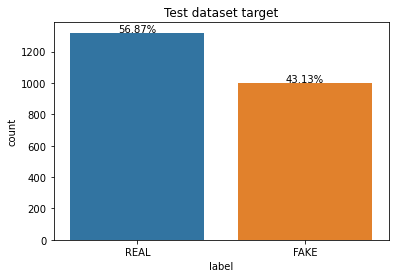

In [78]:
import collections
ax = sns.countplot(predictions.label,
                order=[x for x, count in sorted(collections.Counter(predictions.label).items(),
                key=lambda x: -x[1])])


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(predictions)*100),
            ha="center") 
ax.set_title("Test dataset target")
show()

In [79]:
predictions.drop(columns=["title","text","title_and_text","preprocessed_text","pos_tagged_text","clean_and_pos_tagged_text"]).head()

,ID,label
0,10498,FAKE
1,2439,FAKE
2,864,REAL
3,4128,REAL
4,662,REAL


In [80]:
predictions.to_csv("TEST_PREDICTIONS.csv", index=False)